In [102]:
from altair import *
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

# Open csv file and read rows into a pandas dataframe
df = pd.read_csv('movies.csv')
print "Dataset has {} rows and {} columns.".format(*df.shape)
display(df.head())

Dataset has 108 rows and 5 columns.


,Title,Screen Actors Guild Awards,PGA Awards,"Directors Guild of America, USA","Academy Awards, USA"
0,Michael Clayton,0,0,0,0
1,Chocolat,1,0,0,0
2,In The Bedroom,0,0,0,0
3,Life of Pi,0,0,0,0
4,Sideways,1,0,0,0


# Data Visualization

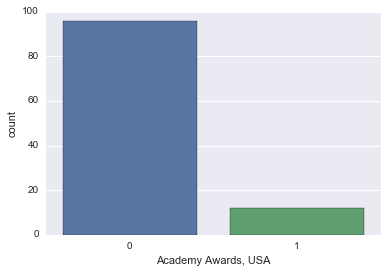

In [103]:
def histogram(data, **bin_kwds):
    """
    Create a Histogram of a 1-dimensional array or series of data
    All parameters are passed to the altair's ``Bin`` class
    """
    return Chart(data).mark_bar().encode(
               x=X('Academy Awards, USA', bin=Bin(**bin_kwds)),
               y='count(*):Q'
           )

#histogram(df, maxbins=20)

_ = sns.countplot(x="Academy Awards, USA", data=df)

# Preprocessing

In [104]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(['Title', 'Academy Awards, USA'], axis=1, inplace=False)
y = df['Academy Awards, USA']

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
for train_ind, test_ind in sss.split(X, y):
    print "TRAIN:", train_ind, "TEST:", test_ind
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

TRAIN: [ 60  30  38  26  67  74  86 105  10  84  19  25  75  32  54  27  71  62
  34  46  14   1   6  95  70  77  85  11  61  40  33  29  37   7  48  47
  43  66 101  91  13  53  99   3  73  63  96  28   2 107  42  89   9  88
  68  87  57  76  94  64 103  81  21  56  51  31  65  23 106  44  58  20
 102  36   0  45   4  39  90  82  72 100  52  50  22  41  49  18  16  79
   5  35  55  93  78  12   8] TEST: [ 98  80 104  15  17  69  59  92  24  83  97]
TRAIN: [ 55   2  12  83  31  67  68  88  13  53  97   6 105  38  95  99  54  58
 106 101  85  17  45  47  37  15 100  22   4 103  61  20  59   0  56  28
  62  70  64  65  51  71  63  14  30  87  90  80  50  44  92  42  34  48
   1  86  74  52   9  79  93   5  21  82  23  24  25  35   3  46  41 102
  89  75 104  84  49  98  26  39  32   7  29  91  57  60   8 107  72  16
  69  76  36  40  73  10  33] TEST: [43 96 78 81 11 94 77 27 66 18 19]
TRAIN: [ 27 106  73  44  21  75  41  31  37  33   6  58  82  51  74   3  77  81
 104  55  69  56  14  9

# Modelling & Evaluation

Training a SVC using a training set size of 97. . .
Trained model in 0.0020 seconds
Report for training set:  Made predictions in 0.0010 seconds.
AUC Score: 0.845137420719
             precision    recall  f1-score   support

          0       0.97      0.87      0.92        86
          1       0.45      0.82      0.58        11

avg / total       0.91      0.87      0.88        97



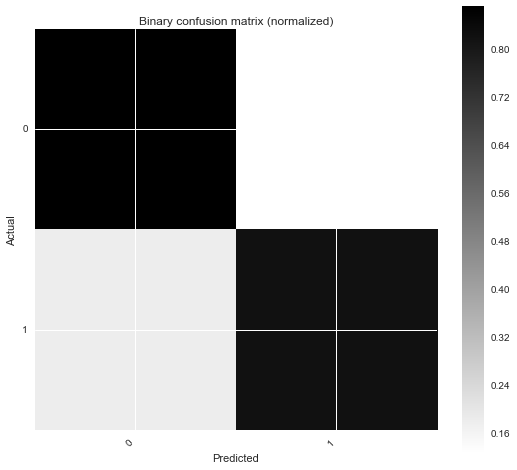

None
Report for test set:  Made predictions in 0.0000 seconds.
AUC Score: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00        11



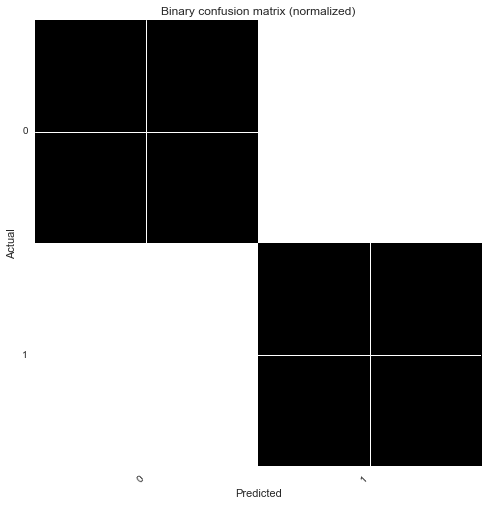

None


In [105]:
# Train model
from time import time
from pandas_ml import ConfusionMatrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    print "AUC Score:", roc_auc_score(target.values, y_pred)
    print classification_report(target.values, y_pred)
    plot_confusion_matrix(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "Report for training set: ", predict_labels(clf, X_train, y_train)
    print "Report for test set: ", predict_labels(clf, X_test, y_test)
    
def plot_confusion_matrix(y_true, y_pred):
    cm = ConfusionMatrix(y_true, y_pred)
    cm.plot(normalized=True)
    plt.show()
    
#clf = SVC(C=100, kernel='sigmoid', class_weight={0: 1, 1: 9}, random_state=42)
clf = SVC(C=1, kernel='rbf', class_weight={0: 1, 1: 9}, random_state=42)

train_predict(clf, X_train, y_train, X_test, y_test)

In [72]:
# Search for optimal parameters
from sklearn.model_selection import GridSearchCV

# Parameters to do GridSearch on
cv_params = {
            'C': [1, 10, 100, 1000],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
            'degree': [3, 2, 1, 4]
            }

# Static model parameters
ind_params = {
            'class_weight': {0: 1, 1: 9},
            'random_state': 42
             }

# Initialize GridSearch with its parameters
optimized_SVC = GridSearchCV(estimator=SVC(**ind_params), 
                             param_grid=cv_params, 
                             scoring='f1',
                             cv=10,
                             n_jobs=-1)

optimized_SVC.fit(X_train, y_train)
#optimized_SVC.cv_results_
print "Best score for training:", optimized_SVC.best_score_
print "Best score parameters:", optimized_SVC.best_params_
print "Score for testing:", optimized_SVC.score(X_test, y_test)

Best score for training: 0.482474226804
Best score parameters: {'kernel': 'sigmoid', 'C': 100, 'degree': 3}
Score for testing: 1.0


In [106]:
# Train final model on full dataset
start = time()
#clf = SVC(C=1, kernel='rbf', class_weight={0: 1, 1: 9}, random_state=42)
clf = SVC(C=100, kernel='sigmoid', class_weight={0: 1, 1: 9}, random_state=42)
clf.fit(X, y)
end = time()

print "Trained model in {:.4f} seconds".format(end - start)

# Saves model for future predictions
from sklearn.externals import joblib
joblib.dump(clf, 'svc.pickle')
print "Model saved."

# Load model
#clf = joblib.load('filename.pickle')

Trained model in 0.0020 seconds
Model saved.


In [107]:
# Predict new labels
df_pred = pd.read_csv('movies_pred.csv')
print "Dataset has {} rows and {} columns.".format(*df_pred.shape)
display(df_pred)

X_pred = df_pred.drop(['Title'], axis=1, inplace=False)

# Load model
clf_pred = joblib.load('svc.pickle')
start = time()
y_pred = clf_pred.predict(X_pred)
end = time()

# Print and return results
print "Made predictions in {:.4f} seconds.".format(end - start)
print ""
print "Predictions for Best Picture:"
for title, pred in zip(df_pred['Title'], y_pred):
    print title, pred

Dataset has 9 rows and 4 columns.


,Title,Screen Actors Guild Awards,PGA Awards,"Directors Guild of America, USA"
0,Moonlight,1,0,0
1,Manchester by the Sea,0,0,0
2,Fences,1,0,0
3,Lion,0,0,1
4,Hacksaw Ridge,1,0,0
5,Hidden Figures,1,0,0
6,La La Land,1,1,1
7,Hell or High Water,0,0,0
8,Arrival,0,0,0


Made predictions in 0.0000 seconds.

Predictions for Best Picture:
Moonlight 0
Manchester by the Sea 0
Fences 0
Lion 1
Hacksaw Ridge 0
Hidden Figures 0
La La Land 1
Hell or High Water 0
Arrival 0
